In [10]:
# Kernel conda_neuron_tensorflow_p38
!neuron-ls

instance-type: inf2.xlarge
instance-id: i-033d817cd3ea0ef0e
+--------+--------+--------+--------------+
| NEURON | NEURON | NEURON |     PCI      |
| DEVICE | CORES  | MEMORY |     BDF      |
+--------+--------+--------+--------------+
| 0      | 2      | 32 GB  | 0000:00:1f.0 |
+--------+--------+--------+--------------+


In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 194.8 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import os
import subprocess

# Paths and settings
TEMP_DIR = './temp'
MODEL_KERAS_PATH = os.path.join(TEMP_DIR, 'model.keras')
IMAGE_PATH = '41f9e920-51b7-44c3-b417-d9ceb0db9ebd.jpg'  # Input image
NEURON_MODEL_PATH = 'neuron_model'  # Path to saved Neuron model


INPUT_SIZE = (384, 384)
NUM_CLASSES = 4

# Color mapping for visualization
color_map = {
    0: [0, 0, 0],      # Black (background)
    1: [255, 0, 0],    # Red (class 1)
    2: [0, 255, 0],    # Green (class 2)
    3: [0, 0, 255]     # Blue (class 3)
}
class_names = ["Background", "Class 1", "Class 2", "Class 3"]

# Enable verbose logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['NEURON_RT_LOG_LEVEL'] = 'DEBUG'
os.environ['NEURON_CC_FLAGS'] = '--log-level DEBUG'

# Check Neuron device status
print("Neuron device status:")
subprocess.run(["neuron-ls"])

# Load models
try:
    keras_model = tf.keras.models.load_model(MODEL_KERAS_PATH, compile=False)
    neuron_model = tf.keras.models.load_model(NEURON_MODEL_PATH)
    print("Models loaded successfully")
except Exception as e:
    print("Failed to load models:", str(e))
    raise

Neuron device status:
instance-type: inf2.xlarge
instance-id: i-033d817cd3ea0ef0e
+--------+--------+--------+--------------+
| NEURON | NEURON | NEURON |     PCI      |
| DEVICE | CORES  | MEMORY |     BDF      |
+--------+--------+--------+--------------+
| 0      | 2      | 32 GB  | 0000:00:1f.0 |
+--------+--------+--------+--------------+


2025-05-06 11:33:43.469620: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Models loaded successfully


In [5]:
# Load and preprocess image
try:
    input_image = Image.open(IMAGE_PATH).convert("RGB")
    input_image = input_image.resize(INPUT_SIZE, Image.BILINEAR)
    input_array = np.array(input_image, dtype=np.float32) / 255.0
    input_array = (input_array - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    input_tensor = np.expand_dims(input_array, axis=0)
    input_tensor = tf.convert_to_tensor(input_tensor, dtype=tf.float32)
    print("Input shape:", input_tensor.shape, "dtype:", input_tensor.dtype)
except Exception as e:
    print("Image preprocessing failed:", str(e))
    raise

Input shape: (1, 384, 384, 3) dtype: <dtype: 'float32'>


In [6]:
# Run inference
try:
    keras_output = keras_model.predict(input_tensor)
    neuron_output = neuron_model.predict(input_tensor)
    print("Keras output shape:", keras_output.shape)
    print("Neuron output shape:", neuron_output.shape)
except Exception as e:
    print("Inference failed:", str(e))
    raise

1/1 [==============================] - 1s 960ms/step


2025-05-06 11:34:33.031452: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.


1/1 [==============================] - 1s 1s/step
Keras output shape: (1, 384, 384, 4)
Neuron output shape: (1, 384, 384, 4)


2025-05-06 11:34:34.207002: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.


In [7]:
# Convert outputs to segmentation masks
keras_mask = np.argmax(keras_output, axis=-1)[0]  # Shape: (384, 384)
neuron_mask = np.argmax(neuron_output, axis=-1)[0]  # Shape: (384, 384)
print("Keras mask unique labels:", np.unique(keras_mask))
print("Neuron mask unique labels:", np.unique(neuron_mask))

# Compute difference mask
difference_mask = (keras_mask != neuron_mask).astype(np.uint8) * 255  # White where different

# Create RGB masks for visualization
def create_rgb_mask(mask, color_map):
    rgb = np.zeros((384, 384, 3), dtype=np.uint8)
    for label in range(NUM_CLASSES):
        rgb[mask == label] = color_map[label]
    return rgb

keras_rgb = create_rgb_mask(keras_mask, color_map)
neuron_rgb = create_rgb_mask(neuron_mask, color_map)

Keras mask unique labels: [0 3]
Neuron mask unique labels: [0 3]


In [8]:
# Save masks
keras_mask_image = Image.fromarray(keras_rgb)
neuron_mask_image = Image.fromarray(neuron_rgb)
difference_image = Image.fromarray(difference_mask)
keras_mask_image.save("keras_segmentation_mask.png")
neuron_mask_image.save("neuron_segmentation_mask.png")
difference_image.save("difference_mask.png")
print("Masks saved: keras_segmentation_mask.png, neuron_segmentation_mask.png, difference_mask.png")

# Compute metrics
pixel_accuracy = np.mean(keras_mask == neuron_mask)
iou_scores = []
for class_id in range(NUM_CLASSES):
    y_true = (keras_mask == class_id).astype(np.uint8)
    y_pred = (neuron_mask == class_id).astype(np.uint8)
    iou = jaccard_score(y_true.flatten(), y_pred.flatten(), zero_division=1)
    iou_scores.append(iou)
mean_iou = np.mean([iou for iou in iou_scores if iou != 1.0])  # Exclude perfect scores (no class)

print(f"Pixel-wise Accuracy: {pixel_accuracy:.4f}")
print(f"Per-class IoU: {', '.join([f'{class_names[i]}: {iou:.4f}' for i, iou in enumerate(iou_scores)])}")
print(f"Mean IoU (excluding perfect scores): {mean_iou:.4f}")

Masks saved: keras_segmentation_mask.png, neuron_segmentation_mask.png, difference_mask.png
Pixel-wise Accuracy: 1.0000
Per-class IoU: Background: 1.0000, Class 1: 1.0000, Class 2: 1.0000, Class 3: 1.0000
Mean IoU (excluding perfect scores): nan


/home/ec2-user/anaconda3/envs/neuron_tensorflow_p38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ec2-user/anaconda3/envs/neuron_tensorflow_p38/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


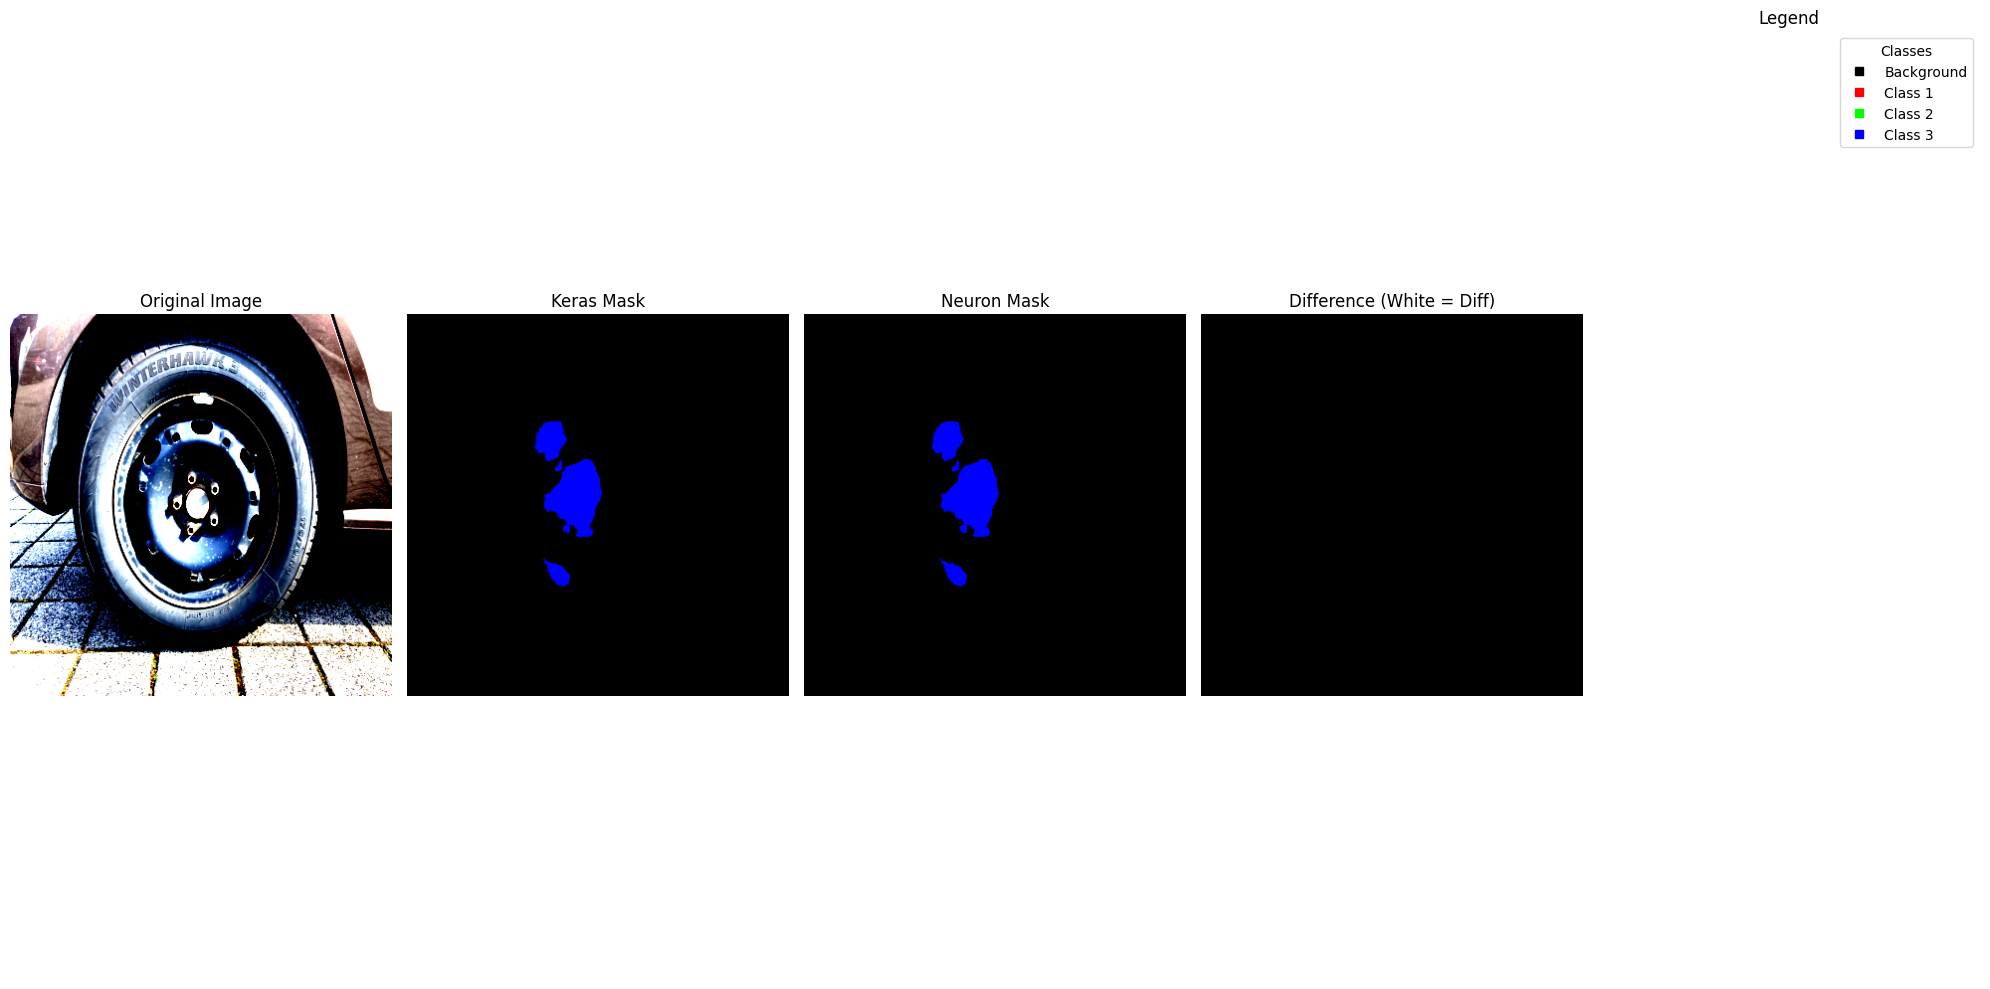

Comparison plot saved as 'segmentation_comparison.png'


In [9]:
# Visualize results
plt.figure(figsize=(20, 10))

# Original image
plt.subplot(1, 5, 1)
plt.imshow(input_array)
plt.title("Original Image")
plt.axis('off')

# Keras mask
plt.subplot(1, 5, 2)
plt.imshow(keras_rgb)
plt.title("Keras Mask")
plt.axis('off')

# Neuron mask
plt.subplot(1, 5, 3)
plt.imshow(neuron_rgb)
plt.title("Neuron Mask")
plt.axis('off')

# Difference mask
plt.subplot(1, 5, 4)
plt.imshow(difference_mask, cmap='gray')
plt.title("Difference (White = Diff)")
plt.axis('off')

# Legend
plt.subplot(1, 5, 5)
plt.axis('off')
for i, (label, color) in enumerate(color_map.items()):
    plt.plot([], [], 's', color=np.array(color)/255, label=class_names[label])
plt.legend(title="Classes")
plt.title("Legend")

plt.tight_layout()
plt.savefig("segmentation_comparison.png")
plt.show()
print("Comparison plot saved as 'segmentation_comparison.png'")

In [11]:
!pip freeze > requirements.txt